### Group 4 ADS508 Final Project

Monitoring Water Quality | Released by Tech-AAB

Team: Parisa Kamizi, Landon Padgett, Vicky van der Wagt

*test change 5:46pm

-----------------------------------------------------------------------

**Import libraries and packages**

In [3]:
import pandas as pd
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
import boto3
import sagemaker
import warnings
from sklearn.preprocessing import LabelEncoder
from io import StringIO
!pip install --disable-pip-version-check -q PyAthena==2.1.0

from pyathena import connect

warnings.filterwarnings("ignore")

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


**Download data from s3 into the "data" folder"**

*Commented out because it only needs to be done once*

In [4]:
!aws s3 cp 's3://ads508group4finalproject/stations.csv' ./data/
!aws s3 cp 's3://ads508group4finalproject/field_results.csv' ./data/
!aws s3 cp 's3://ads508group4finalproject/lab_results.csv' ./data/
!aws s3 cp 's3://ads508group4finalproject/period_of_record.csv' ./data/

download: s3://ads508group4finalproject/stations.csv to data/stations.csv
download: s3://ads508group4finalproject/field_results.csv to data/field_results.csv
download: s3://ads508group4finalproject/lab_results.csv to data/lab_results.csv
download: s3://ads508group4finalproject/period_of_record.csv to data/period_of_record.csv


In [5]:
st = pd.read_csv("./data/stations.csv")
fr = pd.read_csv("./data/field_results.csv")
lr = pd.read_csv("./data/lab_results.csv")
por = pd.read_csv("./data/period_of_record.csv")

## Data Exploration

**Compare df # of rows and columns**

In [6]:
#generate dictionary
df_data = {
    'df': ['st', 'por', 'fr', 'lr'],
    'df longname': ['Stations', 'Period of Record', 'Field Results', 'Lab Results'],
    '# of Rows': [st.shape[0], por.shape[0], fr.shape[0], lr.shape[0]],
    '# of Columns': [st.shape[1], por.shape[1], fr.shape[1], lr.shape[1]]
}

#convert dictionary into dataframe
df_info = pd.DataFrame(df_data)

#print dataframe
print(tabulate(df_info, headers='keys', tablefmt='fancy_grid'))


╒════╤══════╤══════════════════╤═════════════╤════════════════╕
│    │ df   │ df longname      │   # of Rows │   # of Columns │
╞════╪══════╪══════════════════╪═════════════╪════════════════╡
│  0 │ st   │ Stations         │       44475 │             11 │
├────┼──────┼──────────────────┼─────────────┼────────────────┤
│  1 │ por  │ Period of Record │      733915 │             12 │
├────┼──────┼──────────────────┼─────────────┼────────────────┤
│  2 │ fr   │ Field Results    │     1199457 │             22 │
├────┼──────┼──────────────────┼─────────────┼────────────────┤
│  3 │ lr   │ Lab Results      │     4610840 │             18 │
╘════╧══════╧══════════════════╧═════════════╧════════════════╛


**Explore Stations**

In [7]:
st.info()
st.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44475 entries, 0 to 44474
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   station_id         44475 non-null  int64  
 1   station_name       44475 non-null  object 
 2   full_station_name  44475 non-null  object 
 3   station_number     44475 non-null  object 
 4   station_type       44475 non-null  object 
 5   latitude           44197 non-null  float64
 6   longitude          44197 non-null  float64
 7   county_name        44475 non-null  object 
 8   sample_count       44475 non-null  int64  
 9   sample_date_min    44475 non-null  object 
 10  sample_date_max    44475 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 3.7+ MB


,station_id,station_name,full_station_name,station_number,station_type,latitude,longitude,county_name,sample_count,sample_date_min,sample_date_max
0,47023,Frank Sieferman,Frank Sieferman New Well,01N01E01A001M,Groundwater,33.0000,-121.0000,Yolo,1,06/23/2008 15:00,06/23/2008 15:00
1,6134,01N01E33K001M,01N01E33K001M,01N01E33K001M,Groundwater,37.8868,-121.8682,Contra Costa,1,05/20/1981 13:45,05/20/1981 13:45
2,6135,01N01W03N001M,01N01W03N001M,01N01W03N001M,Groundwater,37.9583,-121.9669,Contra Costa,9,07/23/1974 15:15,08/16/1990 12:15
3,6136,01N01W04A001M,01N01W04A001M,01N01W04A001M,Groundwater,37.9663,-121.9734,Contra Costa,9,08/04/1972 15:00,09/15/1989 08:00
4,6137,01N01W07K001M,01N01W07K001M,01N01W07K001M,Groundwater,37.9460,-122.0155,Contra Costa,9,08/03/1973 09:30,09/15/1989 09:15


**See number of stations per county**

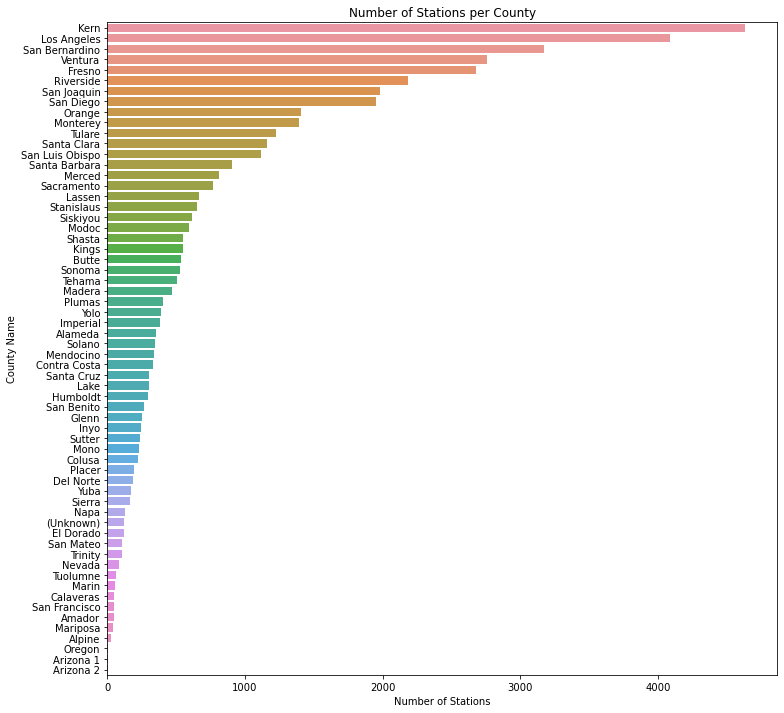

In [8]:
county_station_counts = st['county_name'].value_counts().reset_index()
county_station_counts.columns = ['county_name', 'station_count']

plt.figure(figsize=(12, 12))
sns.barplot(x='station_count', y='county_name', data=county_station_counts)
plt.xlabel('Number of Stations')
plt.ylabel('County Name')
plt.title('Number of Stations per County')
plt.show()


In [9]:
san_diego_stations_count = st[st['county_name'] == 'San Diego'].shape[0]
print("number of San Diego stations:", san_diego_stations_count)

number of San Diego stations: 1948


We have the option to filter for San Diego stations during data processing. This will leave us with 1948 stations remaining.

**See Distribution of Station Types**

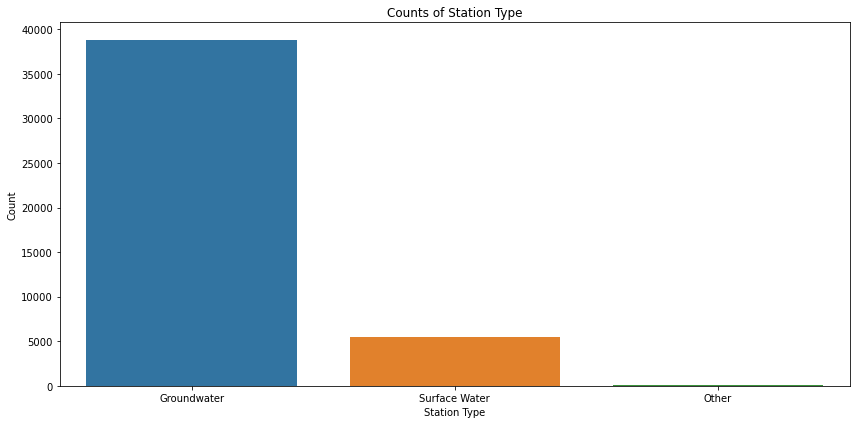

In [10]:
#get count of station types
station_type_counts = st['station_type'].value_counts()

#generate plot
plt.figure(figsize=(12, 6))
sns.barplot(x=station_type_counts.index, y=station_type_counts.values)
plt.xlabel('Station Type')
plt.ylabel('Count')
plt.title('Counts of Station Type')
plt.tight_layout()
plt.show()


## Explore Period of Record

In [11]:
por.info()
por.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733915 entries, 0 to 733914
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   station_id         733915 non-null  int64  
 1   station_name       733915 non-null  object 
 2   full_station_name  733915 non-null  object 
 3   station_number     733915 non-null  object 
 4   station_type       733915 non-null  object 
 5   latitude           723662 non-null  float64
 6   longitude          723662 non-null  float64
 7   county_name        733915 non-null  object 
 8   parameter          733915 non-null  object 
 9   sample_count       733915 non-null  int64  
 10  sample_date_min    733915 non-null  object 
 11  sample_date_max    733915 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 67.2+ MB


,station_id,station_name,full_station_name,station_number,station_type,latitude,longitude,county_name,parameter,sample_count,sample_date_min,sample_date_max
0,47023,Frank Sieferman,Frank Sieferman New Well,01N01E01A001M,Groundwater,33.0,-121.0,Yolo,Dissolved Aluminum,1,06/23/2008 15:00,06/23/2008 15:00
1,47023,Frank Sieferman,Frank Sieferman New Well,01N01E01A001M,Groundwater,33.0,-121.0,Yolo,Dissolved Antimony,1,06/23/2008 15:00,06/23/2008 15:00
2,47023,Frank Sieferman,Frank Sieferman New Well,01N01E01A001M,Groundwater,33.0,-121.0,Yolo,Dissolved Arsenic,1,06/23/2008 15:00,06/23/2008 15:00
3,47023,Frank Sieferman,Frank Sieferman New Well,01N01E01A001M,Groundwater,33.0,-121.0,Yolo,Dissolved Barium,1,06/23/2008 15:00,06/23/2008 15:00
4,47023,Frank Sieferman,Frank Sieferman New Well,01N01E01A001M,Groundwater,33.0,-121.0,Yolo,Dissolved Beryllium,1,06/23/2008 15:00,06/23/2008 15:00


**Examine the Date Range of Water Quality Collection**

In [12]:
#first convert dates in por to datetime
por['sample_date_min'] = pd.to_datetime(por['sample_date_min'])
por['sample_date_max'] = pd.to_datetime(por['sample_date_max'])

#identify the minimum and max values
min_sample_date_min = por['sample_date_min'].min()
max_sample_date_max = por['sample_date_max'].max()

#print
print("Earliest sample_date_min:", min_sample_date_min)
print("Latest sample_date_max:", max_sample_date_max)


Earliest sample_date_min: 1903-03-23 00:00:00
Latest sample_date_max: 2024-01-04 12:59:00


## Explore Lab Results

In [13]:
lr.info()
lr.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4610840 entries, 0 to 4610839
Data columns (total 18 columns):
 #   Column              Dtype  
---  ------              -----  
 0   station_id          int64  
 1   station_name        object 
 2   full_station_name   object 
 3   station_number      object 
 4   station_type        object 
 5   latitude            float64
 6   longitude           float64
 7   status              object 
 8   county_name         object 
 9   sample_code         object 
 10  sample_date         object 
 11  sample_depth        float64
 12  sample_depth_units  object 
 13  parameter           object 
 14  result              object 
 15  reporting_limit     float64
 16  units               object 
 17  method_name         object 
dtypes: float64(4), int64(1), object(13)
memory usage: 633.2+ MB


,station_id,station_name,full_station_name,station_number,station_type,latitude,longitude,status,county_name,sample_code,sample_date,sample_depth,sample_depth_units,parameter,result,reporting_limit,units,method_name
0,8135,01S04E32C001M,01S04E32C001M,01S04E32C001M,Groundwater,37.8073,-121.5617,"Public, Review Status Unknown",Alameda,WDIS_0719152,05/03/1967 09:00,NaN,Feet,Conductance,3480,1.0,uS/cm,EPA 120.1
1,8135,01S04E32C001M,01S04E32C001M,01S04E32C001M,Groundwater,37.8073,-121.5617,"Public, Review Status Unknown",Alameda,WDIS_0719152,05/03/1967 09:00,NaN,Feet,Dissolved Boron,7.7,0.1,mg/L,"Std Method 4500-B, C"
2,8135,01S04E32C001M,01S04E32C001M,01S04E32C001M,Groundwater,37.8073,-121.5617,"Public, Review Status Unknown",Alameda,WDIS_0719152,05/03/1967 09:00,NaN,Feet,Dissolved Calcium,68,1.0,mg/L,EPA 215.2
3,8135,01S04E32C001M,01S04E32C001M,01S04E32C001M,Groundwater,37.8073,-121.5617,"Public, Review Status Unknown",Alameda,WDIS_0719152,05/03/1967 09:00,NaN,Feet,Dissolved Chloride,758,0.1,mg/L,"Std Method 4500-Cl, B"
4,8135,01S04E32C001M,01S04E32C001M,01S04E32C001M,Groundwater,37.8073,-121.5617,"Public, Review Status Unknown",Alameda,WDIS_0719152,05/03/1967 09:00,NaN,Feet,Dissolved Magnesium,59,0.1,mg/L,"Std Method 3500-Mg, E"


**Investigate unique tested parameters**

In [14]:
num_unique_parameters_lr = lr['parameter'].nunique()
print("Number of measured parameters:", num_unique_parameters_lr)

Number of measured parameters: 437


This is a lot of parameters - let's just see distribution of top 30 paramters for now. Can filter later on. 

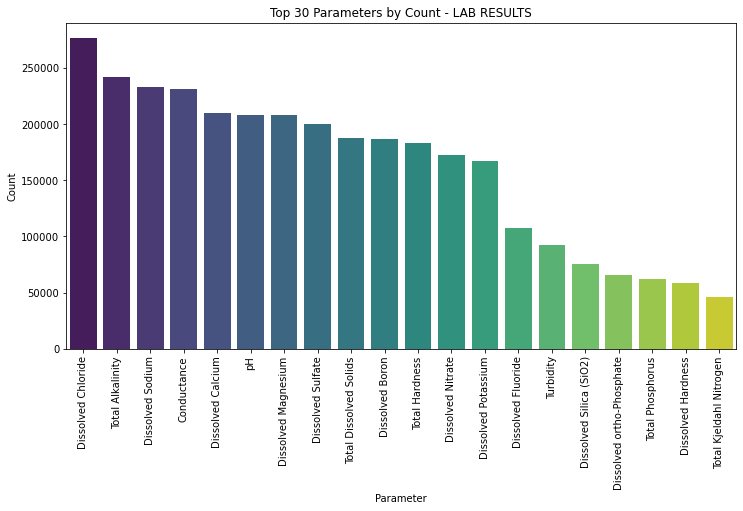

In [15]:
#get the count of each parameter in lr
parameter_counts_lr = lr['parameter'].value_counts()

#generate df for plot
parameter_counts_lr_df = parameter_counts_lr.reset_index()
parameter_counts_lr_df.columns = ['parameter', 'count']

#select top parameters, can change x
x = 20
top_x_parameters_lr = parameter_counts_lr_df.head(20)

#create barplot visualizing the top parameters
plt.figure(figsize=(12, 6))
sns.barplot(x='parameter', y='count', data=top_x_parameters_lr, palette='viridis')
plt.xlabel('Parameter')
plt.ylabel('Count')
plt.title('Top 30 Parameters by Count - LAB RESULTS')
plt.xticks(rotation=90)
plt.show()


## Explore Field Results

In [16]:
fr.info()
fr.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199457 entries, 0 to 1199456
Data columns (total 22 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   station_id           1199457 non-null  int64  
 1   station_name         1199457 non-null  object 
 2   station_number       1199457 non-null  object 
 3   full_station_name    1199457 non-null  object 
 4   station_type         1199457 non-null  object 
 5   latitude             1187572 non-null  float64
 6   longitude            1187572 non-null  float64
 7   status               1199457 non-null  object 
 8   county_name          1199457 non-null  object 
 9   sample_code          1199457 non-null  object 
 10  sample_date          1199457 non-null  object 
 11  sample_depth         634376 non-null   float64
 12  sample_depth_units   1199457 non-null  object 
 13  anl_data_type        136604 non-null   object 
 14  parameter            1199457 non-null  object 
 15

,station_id,station_name,station_number,full_station_name,station_type,latitude,longitude,status,county_name,sample_code,...,sample_depth_units,anl_data_type,parameter,fdr_result,fdr_text_result,fdr_date_result,fdr_reporting_limit,uns_name,mth_name,fdr_footnote
0,12,H.O. Banks Headworks,KA000331,Delta P.P. Headworks at H.O. Banks PP,Surface Water,37.8019,-121.6203,"Public, Review Status Unknown",Alameda,OM0168A0001,...,Feet,NaN,DissolvedOxygen,9.2,NaN,NaN,0.2,mg/L,EPA 360.2 (Field),NaN
1,12,H.O. Banks Headworks,KA000331,Delta P.P. Headworks at H.O. Banks PP,Surface Water,37.8019,-121.6203,"Public, Review Status Unknown",Alameda,OM0168A0001,...,Feet,NaN,ElectricalConductance,515.0,NaN,NaN,1.0,uS/cm,Std Method 2510-B (Field),NaN
2,12,H.O. Banks Headworks,KA000331,Delta P.P. Headworks at H.O. Banks PP,Surface Water,37.8019,-121.6203,"Public, Review Status Unknown",Alameda,OM0168A0001,...,Feet,NaN,WaterTemperature,6.7,NaN,NaN,0.1,°C,EPA 170.1 (Field),NaN
3,12,H.O. Banks Headworks,KA000331,Delta P.P. Headworks at H.O. Banks PP,Surface Water,37.8019,-121.6203,"Public, Review Status Unknown",Alameda,OM0168A0001,...,Feet,NaN,pH,7.3,NaN,NaN,0.1,pH Units,EPA 150.1 (Field),NaN
4,12,H.O. Banks Headworks,KA000331,Delta P.P. Headworks at H.O. Banks PP,Surface Water,37.8019,-121.6203,"Public, Review Status Unknown",Alameda,OM0268A0006,...,Feet,NaN,DissolvedOxygen,9.7,NaN,NaN,0.2,mg/L,EPA 360.2 (Field),NaN


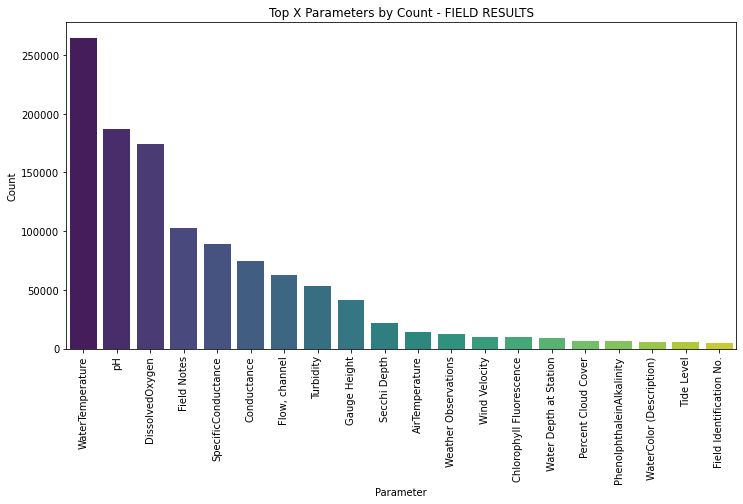

In [17]:
#get the count of each parameter in fr
parameter_counts_fr = fr['parameter'].value_counts()

#generate df for plot
parameter_counts_fr_df = parameter_counts_fr.reset_index()
parameter_counts_fr_df.columns = ['parameter', 'count']

#select top parameters, can change x
x = 20
top_x_parameters_fr = parameter_counts_fr_df.head(20)

#create barplot visualizing the top parameters
plt.figure(figsize=(12, 6))
sns.barplot(x='parameter', y='count', data=top_x_parameters_fr, palette='viridis')
plt.xlabel('Parameter')
plt.ylabel('Count')
plt.title('Top X Parameters by Count - FIELD RESULTS')
plt.xticks(rotation=90)
plt.show()


# Data Preparation 


## Handle Missing Values

In [18]:
# Identify missing values
missing_values_st = st.isnull().sum()
missing_values_por = por.isnull().sum()
missing_values_fr = fr.isnull().sum()
missing_values_lr = lr.isnull().sum()

# Print missing value counts for each dataset
print("Missing Values in Stations dataset:")
print(missing_values_st)
print("\nMissing Values in Period of Record dataset:")
print(missing_values_por)
print("\nMissing Values in Field Results dataset:")
print(missing_values_fr)
print("\nMissing Values in Lab Results dataset:")
print(missing_values_lr)



Missing Values in Stations dataset:
station_id             0
station_name           0
full_station_name      0
station_number         0
station_type           0
latitude             278
longitude            278
county_name            0
sample_count           0
sample_date_min        0
sample_date_max        0
dtype: int64

Missing Values in Period of Record dataset:
station_id               0
station_name             0
full_station_name        0
station_number           0
station_type             0
latitude             10253
longitude            10253
county_name              0
parameter                0
sample_count             0
sample_date_min          0
sample_date_max          0
dtype: int64

Missing Values in Field Results dataset:
station_id                   0
station_name                 0
station_number               0
full_station_name            0
station_type                 0
latitude                 11885
longitude                11885
status                       0
coun

### Creating a Subset of San Diego in Station Dataset

In [19]:
# Create a subset of the data for San Diego County
st_sanDiego = st[st['county_name'] == 'San Diego']

# Show the total count of rows in st_sanDiego dataframe
print("Total count of rows in st_sanDiego dataframe:", st_sanDiego.shape[0])

#Identify missing values
missing_values_st_sanDiego = st_sanDiego.isnull().sum()

# Print missing value counts for each dataset
print("Missing Values in for San Diego county in Stations dataset:")
print(missing_values_st_sanDiego)

# Calculate the percentage of missing values for latitude and longitude columns in st
percentage_missing_latitude_st_sanDiego = (st_sanDiego['latitude'].isnull().sum() / len(st_sanDiego)) * 100
percentage_missing_longitude_st_sanDiego = (st_sanDiego['longitude'].isnull().sum() / len(st_sanDiego)) * 100

print("Percentage of missing values in latitude San Diego County (Stations):", percentage_missing_latitude_st_sanDiego)
print("Percentage of missing values in longitude San Diego County (Stations):", percentage_missing_longitude_st_sanDiego)


Total count of rows in st_sanDiego dataframe: 1948
Missing Values in for San Diego county in Stations dataset:
station_id           0
station_name         0
full_station_name    0
station_number       0
station_type         0
latitude             2
longitude            2
county_name          0
sample_count         0
sample_date_min      0
sample_date_max      0
dtype: int64
Percentage of missing values in latitude San Diego County (Stations): 0.10266940451745381
Percentage of missing values in longitude San Diego County (Stations): 0.10266940451745381


In [20]:
# Drop rows with missing latitude and longitude values in st_sanDiego
st_sanDiego.dropna(subset=['latitude', 'longitude'], inplace=True)

# Identify missing values
missing_values_st_sanDiego = st_sanDiego.isnull().sum()

# Print missing value counts for each dataset
print("Missing Values in San Diego County Stations dataset:")
print(missing_values_st_sanDiego)

# Show the total count of rows after dropping missing values
print("Total count of rows in st_sanDiego dataframe after dropping missing values:", st_sanDiego.shape[0])


Missing Values in San Diego County Stations dataset:
station_id           0
station_name         0
full_station_name    0
station_number       0
station_type         0
latitude             0
longitude            0
county_name          0
sample_count         0
sample_date_min      0
sample_date_max      0
dtype: int64
Total count of rows in st_sanDiego dataframe after dropping missing values: 1946


### Creating a subset in San Diego county in Lab Results 

In [21]:
# Create a subset of the data for San Diego County
lr_sanDiego = lr[lr['county_name'] == 'San Diego']

# Show the total count of rows in lr_sanDiego dataframe
print("Total count of rows in lr_sanDiego dataframe:", lr_sanDiego.shape[0])

#Identify missing values
missing_values_lr_sanDiego = lr_sanDiego.isnull().sum()

# Print missing value counts for each dataset
print("Missing Values in for San Diego county in Lab Result dataset:")
print(missing_values_lr_sanDiego)


Total count of rows in lr_sanDiego dataframe: 101507
Missing Values in for San Diego county in Lab Result dataset:
station_id                 0
station_name               0
full_station_name          0
station_number             0
station_type               0
latitude                  29
longitude                 29
status                     0
county_name                0
sample_code                0
sample_date                0
sample_depth          101069
sample_depth_units         0
parameter                  0
result                   213
reporting_limit          213
units                      0
method_name                0
dtype: int64


In [22]:
# Calculate the percentage of missing values for other columns
percentage_missing_latitude_lr_sanDiego = (lr_sanDiego['latitude'].isnull().sum() / lr_sanDiego.shape[0]) * 100
percentage_missing_longitude_lr_sanDiego = (lr_sanDiego['longitude'].isnull().sum() / lr_sanDiego.shape[0]) * 100
percentage_missing_sample_depth_lr_sanDiego = (lr_sanDiego['sample_depth'].isnull().sum() / len(lr_sanDiego)) * 100
percentage_missing_result_lr_sanDiego = (lr_sanDiego['result'].isnull().sum() / len(lr_sanDiego)) * 100
percentage_missing_reporting_limit_lr_sanDiego = (lr_sanDiego['reporting_limit'].isnull().sum() / len(lr_sanDiego)) * 100

# Print the percentage of missing values for other columns
print("Percentage of missing values in latitude (Lab Results):", percentage_missing_latitude_lr_sanDiego)
print("Percentage of missing values in longitude (Lab Results):", percentage_missing_longitude_lr_sanDiego)
print("Percentage of missing values in sample depth (Lab Results):", percentage_missing_sample_depth_lr_sanDiego)
print("Percentage of missing values in result type (Lab Results):", percentage_missing_result_lr_sanDiego)
print("Percentage of missing values in reporting limit (Lab Results):", percentage_missing_reporting_limit_lr_sanDiego)


Percentage of missing values in latitude (Lab Results): 0.02856945826396209
Percentage of missing values in longitude (Lab Results): 0.02856945826396209
Percentage of missing values in sample depth (Lab Results): 99.56850266484085
Percentage of missing values in result type (Lab Results): 0.20983774518013534
Percentage of missing values in reporting limit (Lab Results): 0.20983774518013534


In [23]:
# Drop rows with missing latitude and longitude values in lr_sanDiego
lr_sanDiego.dropna(subset=['latitude', 'longitude', 'result'], inplace=True)

# Confirm that missing values have been handled
print("Missing values in lr_sanDiego after handling:")
print(lr_sanDiego.isnull().sum())

# Show the total count of rows after dropping missing values
print("Total count of rows in lr_sanDiego dataframe after dropping missing values:", lr_sanDiego.shape[0])


Missing values in lr_sanDiego after handling:
station_id                 0
station_name               0
full_station_name          0
station_number             0
station_type               0
latitude                   0
longitude                  0
status                     0
county_name                0
sample_code                0
sample_date                0
sample_depth          100838
sample_depth_units         0
parameter                  0
result                     0
reporting_limit            0
units                      0
method_name                0
dtype: int64
Total count of rows in lr_sanDiego dataframe after dropping missing values: 101267


In [24]:

# Calculate the mode value of 'sample_depth' column
mode_sample_depth = lr_sanDiego['sample_depth'].mode()[0]

# Replace missing values in 'sample_depth' column with the mode
lr_sanDiego['sample_depth'].fillna(mode_sample_depth, inplace=True)

# Confirm that missing values have been handled
print("Missing values in lr_sanDiego after handling:")
print(lr_sanDiego.isnull().sum())

#Show the total count of rows after dropping missing values
print("Total count of rows in lr_sanDiego dataframe after dropping missing values:", lr_sanDiego.shape[0])


Missing values in lr_sanDiego after handling:
station_id            0
station_name          0
full_station_name     0
station_number        0
station_type          0
latitude              0
longitude             0
status                0
county_name           0
sample_code           0
sample_date           0
sample_depth          0
sample_depth_units    0
parameter             0
result                0
reporting_limit       0
units                 0
method_name           0
dtype: int64
Total count of rows in lr_sanDiego dataframe after dropping missing values: 101267


### Handling Missing Values in Period of Record Dataset

In [25]:
# Create a subset of the data for San Diego County
por_sanDiego = por[por['county_name'] == 'San Diego']

# Show the total count of rows in st_sanDiego dataframe
print("Total count of rows in por_sanDiego dataframe:", por_sanDiego.shape[0])

#Identify missing values
missing_values_por_sanDiego = por_sanDiego.isnull().sum()

#Print missing value counts for period of record dataset
print("Missing Values in for San Diego county in period of record dataset:")
print(missing_values_por_sanDiego)


Total count of rows in por_sanDiego dataframe: 26410
Missing Values in for San Diego county in period of record dataset:
station_id            0
station_name          0
full_station_name     0
station_number        0
station_type          0
latitude             29
longitude            29
county_name           0
parameter             0
sample_count          0
sample_date_min       0
sample_date_max       0
dtype: int64


### Creating a Subset of San Diego in Field Result Dataset

In [26]:
# Create a subset of the data for San Diego County
fr_sanDiego = fr[fr['county_name'] == 'San Diego']

# Show the total count of rows in st_sanDiego dataframe
print("Total count of rows in fr_sanDiego dataframe:", fr_sanDiego.shape[0])

#Identify missing values
missing_values_fr_sanDiego = fr_sanDiego.isnull().sum()

# Print missing value counts for each dataset
print("Missing Values in for San Diego county in field results dataset:")
print(missing_values_fr_sanDiego)

# Calculate the total count of null values in the fr_sanDiego subset dataset
total_null_count_fr_sanDiego = fr_sanDiego.isnull().sum().sum()

# Print the total count of null values
print("Total count of null values in fr_sanDiego dataset:", total_null_count_fr_sanDiego)

# Calculate the total number of data points in fr_sanDiego
total_data_points_fr_sanDiego = fr_sanDiego.size

# Calculate the percentage of missing values
percentage_missing_values_fr_sanDiego = (total_null_count_fr_sanDiego / total_data_points_fr_sanDiego) * 100

# Print the percentage of missing values
print("Percentage of missing values in fr_sanDiego dataset:", percentage_missing_values_fr_sanDiego)



Total count of rows in fr_sanDiego dataframe: 9051
Missing Values in for San Diego county in field results dataset:
station_id                0
station_name              0
station_number            0
full_station_name         0
station_type              0
latitude                  5
longitude                 5
status                    0
county_name               0
sample_code               0
sample_date               0
sample_depth           8698
sample_depth_units        0
anl_data_type          7973
parameter                 0
fdr_result             1083
fdr_text_result        7998
fdr_date_result        9045
fdr_reporting_limit    1114
uns_name                  0
mth_name                  0
fdr_footnote           8080
dtype: int64
Total count of null values in fr_sanDiego dataset: 44001
Percentage of missing values in fr_sanDiego dataset: 22.097508060385092


In [27]:

# Calculate the percentage of missing values for other columns
percentage_missing_latitude_fr_sanDiego = (fr_sanDiego['latitude'].isnull().sum() / fr_sanDiego.shape[0]) * 100
percentage_missing_longitude_fr_sanDiego = (fr_sanDiego['longitude'].isnull().sum() / fr_sanDiego.shape[0]) * 100
percentage_missing_sample_depth_fr_sanDiego = (fr_sanDiego['sample_depth'].isnull().sum() / len(fr_sanDiego)) * 100
percentage_missing_analysis_type_fr_sanDiego = (fr_sanDiego['anl_data_type'].isnull().sum() / len(fr_sanDiego)) * 100
percentage_missing_field_result_fr_sanDiego = (fr_sanDiego['fdr_result'].isnull().sum() / len(fr_sanDiego)) * 100
percentage_missing_field_result_text_fr_sanDiego = (fr_sanDiego['fdr_text_result'].isnull().sum() / len(fr_sanDiego)) * 100
percentage_missing_field_result_date_fr_sanDiego = (fr_sanDiego['fdr_date_result'].isnull().sum() / len(fr_sanDiego)) * 100
percentage_missing_reporting_limit_fr_sanDiego = (fr_sanDiego['fdr_reporting_limit'].isnull().sum() / len(fr_sanDiego)) * 100
percentage_missing_field_result_footnote_fr_sanDiego = (fr_sanDiego['fdr_footnote'].isnull().sum() / len(fr_sanDiego)) * 100

# Print the percentage of missing values for other columns
print("Percentage of missing values in latitude (Field Results):", percentage_missing_latitude_fr_sanDiego)
print("Percentage of missing values in longitude (Field Results):", percentage_missing_longitude_fr_sanDiego)
print("Percentage of missing values in sample depth (Field Results):", percentage_missing_sample_depth_fr_sanDiego)
print("Percentage of missing values in analysis data type (Field Results):", percentage_missing_analysis_type_fr_sanDiego)
print("Percentage of missing values in field result (Field Results):", percentage_missing_field_result_fr_sanDiego)
print("Percentage of missing values in field result text (Field Results):", percentage_missing_field_result_text_fr_sanDiego)
print("Percentage of missing values in field result date (Field Results):", percentage_missing_field_result_date_fr_sanDiego)
print("Percentage of missing values in field result reporting limit (Field Results):", percentage_missing_reporting_limit_fr_sanDiego)
print("Percentage of missing values in field result footnote (Field Results):", percentage_missing_field_result_footnote_fr_sanDiego)


Percentage of missing values in latitude (Field Results): 0.055242514639266375
Percentage of missing values in longitude (Field Results): 0.055242514639266375
Percentage of missing values in sample depth (Field Results): 96.09987846646779
Percentage of missing values in analysis data type (Field Results): 88.08971384377416
Percentage of missing values in field result (Field Results): 11.965528670865098
Percentage of missing values in field result text (Field Results): 88.3659264169705
Percentage of missing values in field result date (Field Results): 99.93370898243288
Percentage of missing values in field result reporting limit (Field Results): 12.308032261628549
Percentage of missing values in field result footnote (Field Results): 89.27190365705448


In [28]:
# Drop rows with missing latitude and longitude values in fr_sanDiego
fr_sanDiego.dropna(subset=['latitude', 'longitude'], inplace=True)

# Replace missing values in other columns with mean values
fr_sanDiego['fdr_result'].fillna(fr_sanDiego['fdr_result'].mean(), inplace=True)
fr_sanDiego['fdr_reporting_limit'].fillna(fr_sanDiego['fdr_reporting_limit'].mean(), inplace=True)

# Confirm that missing values have been handled
print("Missing values in fr_sanDiego after handling:")
print(fr_sanDiego.isnull().sum())


Missing values in fr_sanDiego after handling:
station_id                0
station_name              0
station_number            0
full_station_name         0
station_type              0
latitude                  0
longitude                 0
status                    0
county_name               0
sample_code               0
sample_date               0
sample_depth           8693
sample_depth_units        0
anl_data_type          7968
parameter                 0
fdr_result                0
fdr_text_result        7993
fdr_date_result        9040
fdr_reporting_limit       0
uns_name                  0
mth_name                  0
fdr_footnote           8075
dtype: int64


In [29]:
# Calculate the mode value for each column
sample_depth_mode = fr_sanDiego['sample_depth'].mode()[0]
anl_data_type_mode = fr_sanDiego['anl_data_type'].mode()[0]
fdr_text_result_mode = fr_sanDiego['fdr_text_result'].mode()[0]
fdr_date_result_mode = fr_sanDiego['fdr_date_result'].mode()[0]
fdr_footnote_mode = fr_sanDiego['fdr_footnote'].mode()[0]

# Replace missing values with mode values
fr_sanDiego['sample_depth'].fillna(sample_depth_mode, inplace=True)
fr_sanDiego['anl_data_type'].fillna(anl_data_type_mode, inplace=True)
fr_sanDiego['fdr_text_result'].fillna(fdr_text_result_mode, inplace=True)
fr_sanDiego['fdr_date_result'].fillna(fdr_date_result_mode, inplace=True)
fr_sanDiego['fdr_footnote'].fillna(fdr_footnote_mode, inplace=True)

# Print the null counts after handling missing values
print("Missing values in fr_sanDiego after handling:")
print(fr_sanDiego.isnull().sum())


Missing values in fr_sanDiego after handling:
station_id             0
station_name           0
station_number         0
full_station_name      0
station_type           0
latitude               0
longitude              0
status                 0
county_name            0
sample_code            0
sample_date            0
sample_depth           0
sample_depth_units     0
anl_data_type          0
parameter              0
fdr_result             0
fdr_text_result        0
fdr_date_result        0
fdr_reporting_limit    0
uns_name               0
mth_name               0
fdr_footnote           0
dtype: int64


### Outliers Exploration

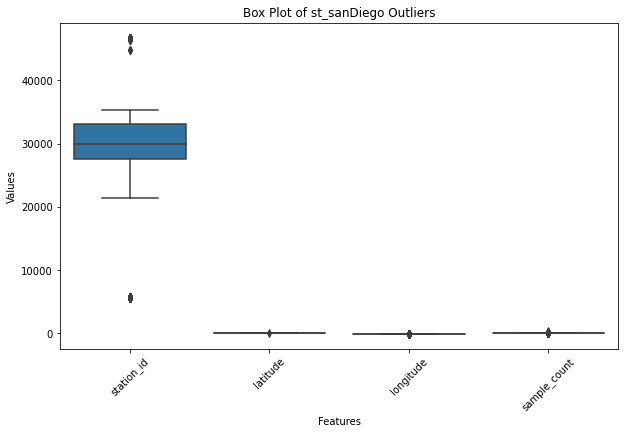

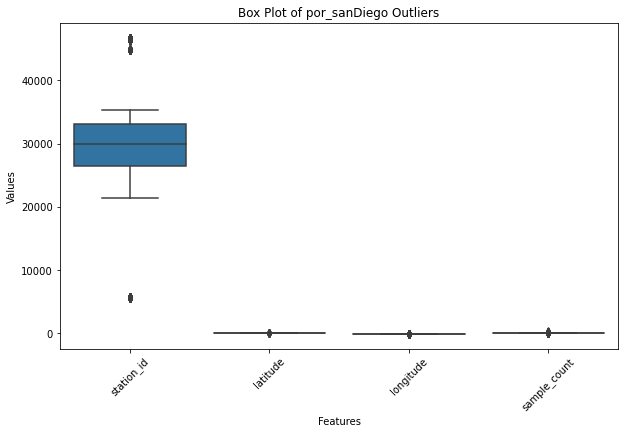

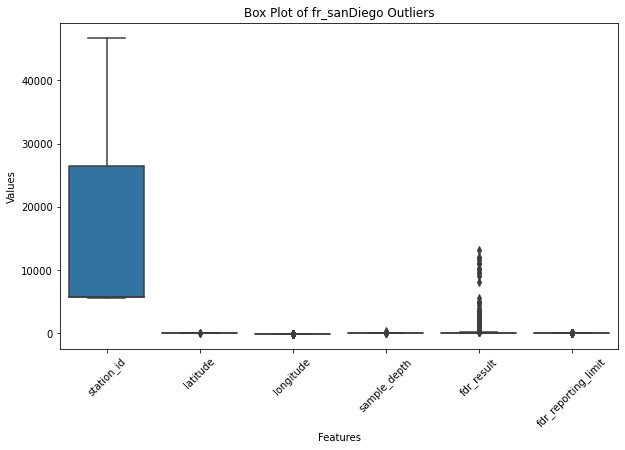

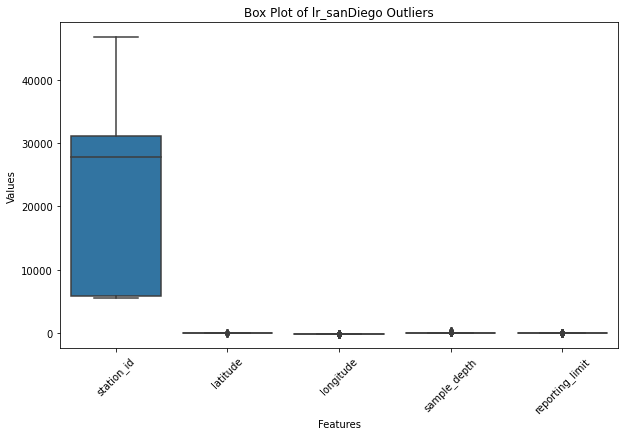

In [30]:


# Create box plots for each dataset to visualize outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=st_sanDiego)  
plt.title('Box Plot of st_sanDiego Outliers')
plt.xlabel('Features')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=por_sanDiego)  
plt.title('Box Plot of por_sanDiego Outliers')
plt.xlabel('Features')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=fr_sanDiego)  
plt.title('Box Plot of fr_sanDiego Outliers')
plt.xlabel('Features')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=lr_sanDiego)  
plt.title('Box Plot of lr_sanDiego Outliers')
plt.xlabel('Features')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()


Feature Creation 

In [31]:
#convert sample_date_min and sample_date_max columns to datetime objects to facilitate time-based analysis
st_sanDiego['sample_date_min'] = pd.to_datetime(st_sanDiego['sample_date_min'], format='%m/%d/%Y %H:%M')
st_sanDiego['sample_date_max'] = pd.to_datetime(st_sanDiego['sample_date_max'], format='%m/%d/%Y %H:%M')

por_sanDiego['sample_date_min'] = pd.to_datetime(por_sanDiego['sample_date_min'], format='%m/%d/%Y %H:%M')
por_sanDiego['sample_date_max'] = pd.to_datetime(por_sanDiego['sample_date_max'], format='%m/%d/%Y %H:%M')

fr_sanDiego['sample_date'] = pd.to_datetime(fr_sanDiego['sample_date'], format='%Y-%m-%d %H:%M:%S')
lr_sanDiego['sample_date'] = pd.to_datetime(lr_sanDiego['sample_date'], format='%m/%d/%Y %H:%M')


One hot encoding for categorical data

In [32]:
st_sanDiego = pd.get_dummies(st_sanDiego, columns=['station_type'], prefix='station_type')


In [33]:
# label encoding using sklearn

label_encoder = LabelEncoder()
st_sanDiego['station_name_encoded'] = label_encoder.fit_transform(st_sanDiego['station_name'])


In [34]:
# label encoding using sklearn

label_encoder = LabelEncoder()
fr_sanDiego['station_name_encoded'] = label_encoder.fit_transform(fr_sanDiego['station_name'])


In [35]:
# label encoding using sklearn

label_encoder = LabelEncoder()
por_sanDiego['station_name_encoded'] = label_encoder.fit_transform(por_sanDiego['station_name'])


In [36]:
# label encoding using sklearn

label_encoder = LabelEncoder()
lr_sanDiego['station_name_encoded'] = label_encoder.fit_transform(lr_sanDiego['station_name'])


### Dropping Unnecessary Columns for each dataset

In [37]:
# Define the columns to keep
st_sanDiego_columns = ['station_id', 'latitude', 'longitude', 'county_name']

# Filter the DataFrame to keep only the desired columns
st_sanDiego_df = st_sanDiego[st_sanDiego_columns]

print(st_sanDiego_df.head())  


       station_id  latitude  longitude county_name
15284       21453   33.6110  -117.6241   San Diego
16696       22879   33.5428  -117.1425   San Diego
16735       22919   33.5825  -117.2447   San Diego
17749       23932   33.4289  -116.8370   San Diego
17851       24039   33.4330  -117.2228   San Diego


In [38]:
por_sanDiego_columns = ['station_id', 'latitude', 'longitude', 'county_name', 'parameter']

# Filter the DataFrame to keep only the desired columns
por_sanDiego_df = por_sanDiego[por_sanDiego_columns]

print(por_sanDiego_df.head())  

        station_id  latitude  longitude county_name           parameter
211730       21453    33.611  -117.6241   San Diego         Conductance
211731       21453    33.611  -117.6241   San Diego     Dissolved Boron
211732       21453    33.611  -117.6241   San Diego   Dissolved Calcium
211733       21453    33.611  -117.6241   San Diego  Dissolved Chloride
211734       21453    33.611  -117.6241   San Diego  Dissolved Fluoride


In [39]:
# Define the columns to keep
fr_sanDiego_columns = ['station_id', 'latitude', 'longitude', 'sample_date','county_name', 'parameter', 'fdr_result', 'uns_name']

# Filter the DataFrame to keep only the desired columns
fr_sanDiego_df = fr_sanDiego[fr_sanDiego_columns]

print(fr_sanDiego_df.head())  
fr_sanDiego_df.head()

        station_id  latitude  longitude         sample_date county_name  \
682387        5576   33.1542    -116.48 1988-04-27 11:00:00   San Diego   
682388        5576   33.1542    -116.48 1988-04-27 11:00:00   San Diego   
682389        5576   33.1542    -116.48 1988-04-27 11:00:00   San Diego   
682390        5576   33.1542    -116.48 1988-04-27 11:00:00   San Diego   
682391        5576   33.1542    -116.48 1988-04-27 11:00:00   San Diego   

               parameter   fdr_result uns_name  
682387       Field Notes   172.100771           
682388       Conductance  1250.000000    uS/cm  
682389   DissolvedOxygen     6.300000     mg/L  
682390     Flow, channel     0.000000      cfs  
682391  WaterTemperature    71.000000       °F  


,station_id,latitude,longitude,sample_date,county_name,parameter,fdr_result,uns_name
682387,5576,33.1542,-116.48,1988-04-27 11:00:00,San Diego,Field Notes,172.100771,
682388,5576,33.1542,-116.48,1988-04-27 11:00:00,San Diego,Conductance,1250.000000,uS/cm
682389,5576,33.1542,-116.48,1988-04-27 11:00:00,San Diego,DissolvedOxygen,6.300000,mg/L
682390,5576,33.1542,-116.48,1988-04-27 11:00:00,San Diego,"Flow, channel",0.000000,cfs
682391,5576,33.1542,-116.48,1988-04-27 11:00:00,San Diego,WaterTemperature,71.000000,°F


In [40]:


# Define the columns to keep
lr_sanDiego_columns = ['station_id', 'sample_date', 'latitude', 'longitude', 'county_name', 'parameter', 'result', 'units']

# Filter the DataFrame to keep only the desired columns
lr_sanDiego_df = lr_sanDiego[lr_sanDiego_columns]

print(lr_sanDiego_df.head())  


         station_id sample_date  latitude  longitude county_name  \
3092634       21453  1964-07-16    33.611  -117.6241   San Diego   
3092635       21453  1964-07-16    33.611  -117.6241   San Diego   
3092636       21453  1964-07-16    33.611  -117.6241   San Diego   
3092637       21453  1964-07-16    33.611  -117.6241   San Diego   
3092638       21453  1964-07-16    33.611  -117.6241   San Diego   

                  parameter result  units  
3092634         Conductance    660  uS/cm  
3092635     Dissolved Boron    .02   mg/L  
3092636   Dissolved Calcium     61   mg/L  
3092637  Dissolved Chloride     69   mg/L  
3092638  Dissolved Fluoride     .2   mg/L  


In [41]:
# Assuming you have already loaded the four datasets into DataFrames named st_sanDiego_df, por_sanDiego_df, fr_sanDiego_df, and lr_sanDiego_df

# Merge st_sanDiego_df with por_sanDiego_df on 'station_id'
#merged_df = st_sanDiego_df.merge(por_sanDiego_df[['station_id', 'latitude', 'longitude', 'county_name', 'parameter']], on='station_id', how='left')

# Merge merged_df with fr_sanDiego_df on 'station_id'
#merged_df = merged_df.merge(fr_sanDiego_df[['station_id', 'latitude', 'longitude', 'county_name', 'parameter', 'fdr_result', 'uns_name']], on='station_id', how='left')

# Merge merged_df with lr_sanDiego_df on 'station_id'
#merged_df = merged_df.merge(lr_sanDiego_df[['station_id', 'latitude', 'longitude', 'county_name', 'parameter', 'result', 'units']], on='station_id', how='left')

# Now merged_df contains the combined data from all four datasets using 'station_id' as the key
#print(merged_df.head())  # Optionally, you can print the first few rows to verify



### Reformat Lab and Field Results; Extract Parameters as Fields

**Filter for which parameters to keep in lab and field results.**

In [42]:
#filter num. How many parameters do we want to evaluate? Probably 10. 

lr_filter = ['Dissolved Chlorine', 'Total Alkalinity', 'Dissolved Sodium', 'Conductance', 'Dissolved Calcium', 'pH']
fr_filter = ['WaterTemperature','pH','DissolvedOxygen','SpecificConductance','Conductance','Turbidity']

lr_sanDiego_df_filtered = lr_sanDiego_df[lr_sanDiego_df['parameter'].isin(lr_filter)]
fr_sanDiego_df_filtered = fr_sanDiego_df[fr_sanDiego_df['parameter'].isin(fr_filter)]

**Pivot Fields in Lab Results.**

In [43]:
pivot_lr_sd = lr_sanDiego_df_filtered.pivot_table(index=['station_id', 'sample_date', 'latitude', 'longitude', 'county_name'], 
                                                 columns='parameter', 
                                                 values=['result', 'units'], 
                                                 aggfunc={'result': 'first', 'units': 'first'}).reset_index()
pivot_lr_sd = pivot_lr_sd.sort_values(by='sample_date')


pivot_lr_sd.tail()

station_id         sample_date latitude longitude county_name  \
parameter                                                                 
1117            5762 2001-11-28 10:45:00  33.1145 -117.1300   San Diego   
1437            5765 2001-11-28 12:00:00  32.8389 -117.0425   San Diego   
445             5643 2002-05-08 10:00:00  33.3984 -117.2625   San Diego   
1118            5762 2002-05-08 11:15:00  33.1145 -117.1300   San Diego   
1438            5765 2002-05-08 12:15:00  32.8389 -117.0425   San Diego   

               result                                                      \
parameter Conductance Dissolved Calcium Dissolved Sodium Total Alkalinity   
1117              NaN               105              194              250   
1437              NaN                75              NaN              NaN   
445               NaN               111              119              198   
1118              NaN                97              210              311   
1438              NaN                98              NaN              NaN   

                     units                                     \
parameter   pH Conductance Dissolved Calcium Dissolved Sodium   
1117       NaN         NaN              mg/L             mg/L   
1437       NaN         NaN              mg/L              NaN   
445        NaN         NaN              mg/L             mg/L   
1118       NaN         NaN              mg/L             mg/L   
1438       NaN         NaN              mg/L              NaN   

                                 
parameter Total Alkalinity   pH  
1117         mg/L as CaCO3  NaN  
1437                   NaN  NaN  
445          mg/L as CaCO3  NaN  
1118         mg/L as CaCO3  NaN  
1438                   NaN  NaN

**Pivot Fields in Field Results**

In [44]:
pivot_fr_sd = fr_sanDiego_df_filtered.pivot_table(index=['station_id', 'sample_date', 'latitude', 'longitude', 'county_name'], 
                                         columns='parameter', 
                                         values=['fdr_result', 'uns_name'], 
                                         aggfunc={'fdr_result': 'first', 'uns_name': 'first'}).reset_index()

# Remove the name of the index column
pivot_fr_sd.columns = [' '.join(col).strip() for col in pivot_fr_sd.columns.values]
pivot_fr_sd = pivot_fr_sd.sort_values(by='sample_date')


pivot_fr_sd.head()


,station_id,sample_date,latitude,longitude,county_name,fdr_result Conductance,fdr_result DissolvedOxygen,fdr_result SpecificConductance,fdr_result WaterTemperature,fdr_result pH,uns_name Conductance,uns_name DissolvedOxygen,uns_name SpecificConductance,uns_name WaterTemperature,uns_name pH
2217,27915,1949-12-22 00:00:00,33.2186,-117.3409,San Diego,NaN,NaN,NaN,64.0,NaN,NaN,NaN,NaN,°F,NaN
2481,28000,1949-12-23 11:30:00,33.2112,-117.3568,San Diego,NaN,NaN,NaN,64.0,NaN,NaN,NaN,NaN,°F,NaN
609,5762,1950-12-21 14:00:00,33.1145,-117.1300,San Diego,1680.0,NaN,NaN,NaN,NaN,uS/cm,NaN,NaN,NaN,NaN
157,5643,1951-02-14 08:50:00,33.3984,-117.2625,San Diego,NaN,NaN,NaN,NaN,8.4,NaN,NaN,NaN,NaN,pH Units
610,5762,1951-03-01 15:15:00,33.1145,-117.1300,San Diego,1420.0,NaN,NaN,NaN,NaN,uS/cm,NaN,NaN,NaN,NaN


**converting fahrenheit to celcius**

In [45]:
# Convert 'fdr_result WaterTemperature' from Fahrenheit to Celsius if 'uns_name WaterTemperature' is '°F'
fahrenheit_mask = pivot_fr_sd['uns_name WaterTemperature'] == '°F'
pivot_fr_sd.loc[fahrenheit_mask, 'fdr_result WaterTemperature'] = (
    (pivot_fr_sd.loc[fahrenheit_mask, 'fdr_result WaterTemperature'] - 32) * 5/9
)

# Change 'uns_name WaterTemperature' to '°C' for rows where temperature is in Celsius
pivot_fr_sd.loc[fahrenheit_mask, 'uns_name WaterTemperature'] = '°C'

#sort columns by sample date.

pivot_fr_sd.head()

,station_id,sample_date,latitude,longitude,county_name,fdr_result Conductance,fdr_result DissolvedOxygen,fdr_result SpecificConductance,fdr_result WaterTemperature,fdr_result pH,uns_name Conductance,uns_name DissolvedOxygen,uns_name SpecificConductance,uns_name WaterTemperature,uns_name pH
2217,27915,1949-12-22 00:00:00,33.2186,-117.3409,San Diego,NaN,NaN,NaN,17.777778,NaN,NaN,NaN,NaN,°C,NaN
2481,28000,1949-12-23 11:30:00,33.2112,-117.3568,San Diego,NaN,NaN,NaN,17.777778,NaN,NaN,NaN,NaN,°C,NaN
609,5762,1950-12-21 14:00:00,33.1145,-117.1300,San Diego,1680.0,NaN,NaN,NaN,NaN,uS/cm,NaN,NaN,NaN,NaN
157,5643,1951-02-14 08:50:00,33.3984,-117.2625,San Diego,NaN,NaN,NaN,NaN,8.4,NaN,NaN,NaN,NaN,pH Units
610,5762,1951-03-01 15:15:00,33.1145,-117.1300,San Diego,1420.0,NaN,NaN,NaN,NaN,uS/cm,NaN,NaN,NaN,NaN


## Descriptive Statistics of Data within Pivot Fields

In [46]:
stats_fr = pivot_fr_sd.describe().transpose()

# Descriptive statistics for pivot_lr_sd
stats_lr = pivot_lr_sd.describe().transpose()

# Plotting
print("Descriptive Statistics for pivot_fr_sd:")
print(stats_fr)

print("\nDescriptive Statistics for pivot_lr_sd:")
print(stats_lr)

Descriptive Statistics for pivot_fr_sd:
                                 count          mean           std  \
station_id                      3857.0  21018.671506  12349.460470   
latitude                        3857.0     33.041093      0.287922   
longitude                       3857.0   -117.112701      0.262136   
fdr_result Conductance           597.0   1798.368509   1458.629956   
fdr_result DissolvedOxygen       966.0      8.613976      6.000063   
fdr_result SpecificConductance    26.0   1597.153846    368.421030   
fdr_result WaterTemperature     3731.0     20.300622      4.398005   
fdr_result pH                   1212.0      7.732261      0.441947   

                                        min          25%         50%  \
station_id                      5576.000000  5765.000000  27526.0000   
latitude                          32.541700    32.831500     33.1145   
longitude                       -121.855400  -117.262500   -117.1086   
fdr_result Conductance           176.0000

## Exploring Missing Values in Pivot Fields

Table of Missing Values for pivot_fr_sd:
station_id                           0
sample_date                          0
latitude                             0
longitude                            0
county_name                          0
fdr_result Conductance            3260
fdr_result DissolvedOxygen        2891
fdr_result SpecificConductance    3831
fdr_result WaterTemperature        126
fdr_result pH                     2645
uns_name Conductance              3260
uns_name DissolvedOxygen          2891
uns_name SpecificConductance      3831
uns_name WaterTemperature          126
uns_name pH                       2645
dtype: int64


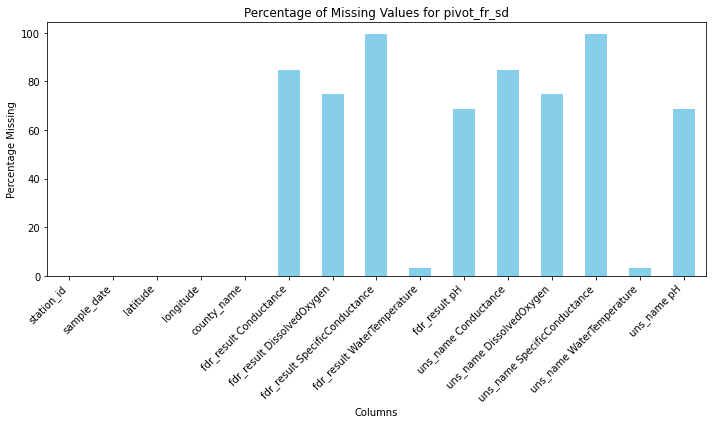

In [47]:
# Define pivot_lr_sd
pivot_lr_sd = lr_sanDiego_df_filtered.pivot_table(index=['station_id', 'sample_date', 'latitude', 'longitude', 'county_name'], 
                                                 columns='parameter', 
                                                 values=['result', 'units'], 
                                                 aggfunc={'result': 'first', 'units': 'first'}).reset_index()
pivot_lr_sd = pivot_lr_sd.sort_values(by='sample_date')

# Define pivot_fr_sd
pivot_fr_sd = fr_sanDiego_df_filtered.pivot_table(index=['station_id', 'sample_date', 'latitude', 'longitude', 'county_name'], 
                                         columns='parameter', 
                                         values=['fdr_result', 'uns_name'], 
                                         aggfunc={'fdr_result': 'first', 'uns_name': 'first'}).reset_index()

# Remove the name of the index column
pivot_fr_sd.columns = [' '.join(col).strip() for col in pivot_fr_sd.columns.values]
pivot_fr_sd = pivot_fr_sd.sort_values(by='sample_date')

# Table of missing values for pivot_fr_sd
missing_values_fr = pivot_fr_sd.isnull().sum()
print("Table of Missing Values for pivot_fr_sd:")
print(missing_values_fr)

missing_percentage_fr = (pivot_fr_sd.isnull().sum() / len(pivot_fr_sd)) * 100

# Plot bar chart for missing values
plt.figure(figsize=(10, 6))
missing_percentage_fr.plot(kind='bar', color='skyblue')
plt.title('Percentage of Missing Values for pivot_fr_sd')
plt.xlabel('Columns')
plt.ylabel('Percentage Missing')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## save transformed files as csv

**stations**

In [48]:
csv_buffer = StringIO()
st_sanDiego_df.to_csv(csv_buffer, index=False)

# Upload CSV string to S3
bucket_name = 'ads508group4finalproject'
subfolder_name = 'stations_transformed'
file_name = 'stations_transformed.csv'
s3_key = f'{subfolder_name}/{file_name}'

s3_client = boto3.client('s3')
s3_client.put_object(Body=csv_buffer.getvalue(), Bucket=bucket_name, Key=s3_key)



{'ResponseMetadata': {'RequestId': '0R1TSB4N75WANR29',
  'HostId': 'aO32hQzjjaNeSAhihnzlOd2s4bOWmn1i9ehSMUmgitjGQg7/EKgczg46Sc4ROP/4cm2HK6515Q8=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'aO32hQzjjaNeSAhihnzlOd2s4bOWmn1i9ehSMUmgitjGQg7/EKgczg46Sc4ROP/4cm2HK6515Q8=',
   'x-amz-request-id': '0R1TSB4N75WANR29',
   'date': 'Wed, 03 Apr 2024 01:39:33 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"448df0aaca6c187188c71e2f9bc7617d"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"448df0aaca6c187188c71e2f9bc7617d"',
 'ServerSideEncryption': 'AES256'}

**period of record**

In [49]:
csv_buffer = StringIO()
por_sanDiego_df.to_csv(csv_buffer, index=False)

# Upload CSV string to S3
bucket_name = 'ads508group4finalproject'
subfolder_name = 'period_of_record_transformed'
file_name = 'period_of_record_transformed.csv'
s3_key = f'{subfolder_name}/{file_name}'

s3_client = boto3.client('s3')
s3_client.put_object(Body=csv_buffer.getvalue(), Bucket=bucket_name, Key=s3_key)


{'ResponseMetadata': {'RequestId': '0R1G6DK4CE3F7CZ7',
  'HostId': 'pH3qgkwKRoQ7I5RQAJPoQxT3bBSFW0e5dkI3PMznarEeeBb3ZsymHpBjfrl21Zw7pxJfkbsYJGM=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'pH3qgkwKRoQ7I5RQAJPoQxT3bBSFW0e5dkI3PMznarEeeBb3ZsymHpBjfrl21Zw7pxJfkbsYJGM=',
   'x-amz-request-id': '0R1G6DK4CE3F7CZ7',
   'date': 'Wed, 03 Apr 2024 01:39:33 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"5b0b8963ac15f4ffc186de742907892a"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"5b0b8963ac15f4ffc186de742907892a"',
 'ServerSideEncryption': 'AES256'}

**field results**

In [50]:
csv_buffer = StringIO()
pivot_fr_sd.to_csv(csv_buffer, index=False)
#Upload CSV string to S3
    
bucket_name = 'ads508group4finalproject'
subfolder_name = 'field_results_transformed'
file_name = 'field_results_transformed.csv'
s3_key = f'{subfolder_name}/{file_name}'

s3_client = boto3.client('s3')
s3_client.put_object(Body=csv_buffer.getvalue(), Bucket=bucket_name, Key=s3_key)

{'ResponseMetadata': {'RequestId': '0R1VQ75FJTQNZ3GV',
  'HostId': 'mRcHzej0iLqdOsDcWAuBvMaWxXvk36cOrKk+p/7wvwD+ZahoHLQR63XyRxhhczvJX47/JZOXWX4=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'mRcHzej0iLqdOsDcWAuBvMaWxXvk36cOrKk+p/7wvwD+ZahoHLQR63XyRxhhczvJX47/JZOXWX4=',
   'x-amz-request-id': '0R1VQ75FJTQNZ3GV',
   'date': 'Wed, 03 Apr 2024 01:39:33 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"fd5c3d0aeb2f6af51946fdb43be0efca"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"fd5c3d0aeb2f6af51946fdb43be0efca"',
 'ServerSideEncryption': 'AES256'}

**lab results**

In [51]:
csv_buffer = StringIO()
pivot_lr_sd.to_csv(csv_buffer, index=False)


#Upload CSV string to S3
bucket_name = 'ads508group4finalproject'
subfolder_name = 'lab_results_transformed'
file_name = 'lab_results_transformed.csv'
s3_key = f'{subfolder_name}/{file_name}'

s3_client = boto3.client('s3')
s3_client.put_object(Body=csv_buffer.getvalue(), Bucket=bucket_name, Key=s3_key)

{'ResponseMetadata': {'RequestId': '0R1GJGFERHS9YWQR',
  'HostId': 'SZNkUG3UzxV9WuAVFqPL2OX7cnndVeAF8PY3E12rbBTpdMoGVeEn66DocU/ruMoYG8KZtiqSlJI=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'SZNkUG3UzxV9WuAVFqPL2OX7cnndVeAF8PY3E12rbBTpdMoGVeEn66DocU/ruMoYG8KZtiqSlJI=',
   'x-amz-request-id': '0R1GJGFERHS9YWQR',
   'date': 'Wed, 03 Apr 2024 01:39:33 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"285e343de12cde3ad3ed871464667ee6"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"285e343de12cde3ad3ed871464667ee6"',
 'ServerSideEncryption': 'AES256'}

## Athena Database

**Import Pyathena**

In [52]:
bucket = 'ads508group4finalproject'
database_name = "ADS508Group4"
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)
region = 'us-east-1'

statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)

pd.read_sql(statement,conn)

statement = "SHOW DATABASES"
df_show = pd.read_sql(statement,conn)
df_show.head(5)


CREATE DATABASE IF NOT EXISTS ADS508Group4


,database_name
0,ads508group4
1,default


# Create Database Tables and import Data

**Stations Table**

In [53]:
#define parameters
region = 'us-east-1'
bucket = 'ads508group4finalproject'
s3_staging_dir = "s3://{}/athena/staging".format(bucket)

#specify location of where the file that we will ingest data from is located
subfolder = "stations_transformed"
loc = 's3://{}/{}/'.format(bucket, subfolder)
#specify database name and database table name
database_name = "ADS508Group4"
table_name = "stations"

#connect to athena
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)
cur = conn.cursor()

# sql statement to make table
make_stations_table = """
    CREATE EXTERNAL TABLE IF NOT EXISTS {}.{} (
        station_id string,
        latitude double,
        longitude double,
        county_name string
    ) ROW FORMAT DELIMITED
    FIELDS TERMINATED BY ','
    LINES TERMINATED BY '\\n'
    LOCATION '{}'
    TBLPROPERTIES ('compressionType'='gzip', 'skip.header.line.count'='1')
""".format(database_name, table_name, loc)

#execute sql statement
cur.execute(make_stations_table)

#preview first 5 rows
head_query = "SELECT * FROM {}.{} LIMIT 5".format(database_name, table_name)
df_first_5_rows = pd.read_sql(head_query, conn)
print(df_first_5_rows)

  station_id  latitude  longitude county_name
0      21453   33.6110  -117.6241   San Diego
1      22879   33.5428  -117.1425   San Diego
2      22919   33.5825  -117.2447   San Diego
3      23932   33.4289  -116.8370   San Diego
4      24039   33.4330  -117.2228   San Diego


**Field Results Table**

In [54]:
#define parameters
region = 'us-east-1'
bucket = 'ads508group4finalproject'
s3_staging_dir = "s3://{}/athena/staging".format(bucket)

# Specify the location of the file from which data will be ingested
subfolder = "field_results_transformed"
loc = 's3://{}/{}/'.format(bucket, subfolder)

# Specify the database name and table name
database_name = "ADS508Group4"
table_name = "field_results"

# Connect to Athena
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)
cur = conn.cursor()

# SQL statement to create the table for field results
make_field_results_table = """
    CREATE EXTERNAL TABLE IF NOT EXISTS {}.{} (
        station_id string,
        sample_date string,
        latitude double,
        longitude double,
        county_name string,
        -- Add more columns as needed based on your field results data
        parameter1 string,
        parameter2 string,
        result1 double,
        result2 double,
        units1 string,
        units2 string
    ) ROW FORMAT DELIMITED
    FIELDS TERMINATED BY ','
    LINES TERMINATED BY '\\n'
    LOCATION '{}'
    TBLPROPERTIES ('compressionType'='gzip', 'skip.header.line.count'='1')
""".format(database_name, table_name, loc)

# Execute the SQL statement to create the table
cur.execute(make_field_results_table)

# Preview first 5 rows
head_query = "SELECT * FROM {}.{} LIMIT 5".format(database_name, table_name)
df_first_5_rows = pd.read_sql(head_query, conn)
print(df_first_5_rows)

  station_id          sample_date  latitude  longitude county_name parameter1  \
0      27915  1949-12-22 00:00:00   33.2186  -117.3409   San Diego              
1      28000  1949-12-23 11:30:00   33.2112  -117.3568   San Diego              
2       5762  1950-12-21 14:00:00   33.1145  -117.1300   San Diego     1680.0   
3       5643  1951-02-14 08:50:00   33.3984  -117.2625   San Diego              
4       5762  1951-03-01 15:15:00   33.1145  -117.1300   San Diego     1420.0   

  parameter2 result1  result2 units1 units2  
0               None     64.0                
1               None     64.0                
2               None      NaN         uS/cm  
3               None      NaN    8.4         
4               None      NaN         uS/cm  


**Lab Results Tables**

In [55]:
# Define parameters
region = 'us-east-1'
bucket = 'ads508group4finalproject'
s3_staging_dir = "s3://{}/athena/staging".format(bucket)

# Specify the location of the file from which data will be ingested
subfolder = "lab_results_transformed"
loc = 's3://{}/{}/'.format(bucket, subfolder)

# Specify the database name and table name
database_name = "ADS508Group4"
table_name = "lab_results"

# Connect to Athena
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)
cur = conn.cursor()

# SQL statement to create the table for lab results
make_lab_results_table = """
    CREATE EXTERNAL TABLE IF NOT EXISTS {}.{} (
        station_id string,
        station_name string,
        full_station_name string,
        station_number string,
        station_type string,
        latitude double,
        longitude double,
        status string,
        county_name string,
        sample_code string,
        sample_date string,
        sample_depth double,
        sample_depth_units string,
        parameter string,
        result double,
        reporting_limit double,
        units string,
        method_name string
    ) ROW FORMAT DELIMITED
    FIELDS TERMINATED BY ','
    LINES TERMINATED BY '\\n'
    LOCATION '{}'
    TBLPROPERTIES ('compressionType'='gzip', 'skip.header.line.count'='1')
""".format(database_name, table_name, loc)

# Execute the SQL statement to create the table for lab results
cur.execute(make_lab_results_table)

# Preview first 5 rows
head_query = "SELECT * FROM {}.{} LIMIT 5".format(database_name, table_name)
df_first_5_rows = pd.read_sql(head_query, conn)
print(df_first_5_rows)

  station_id         station_name full_station_name station_number  \
0                                                                    
1      29246  1917-11-20 00:00:00           33.1139       -115.826   
2      46749  1917-11-24 00:00:00           32.6183      -116.2006   
3      32161  1917-11-26 00:00:00           32.8807       -116.103   
4      32162  1917-11-26 00:00:00           32.8807       -116.103   

  station_type latitude  longitude            status       county_name  \
0                  None        NaN  Dissolved Sodium  Total Alkalinity   
1    San Diego     None       30.0               705               170   
2    San Diego     None       43.0                                 182   
3    San Diego     None      100.0               338               150   
4    San Diego     None      100.0               338               150   

  sample_code  sample_date sample_depth sample_depth_units         parameter  \
0          pH  Conductance         None   Dissolved So

# Modeling

**Logistic Regression Model**

In [56]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Define a pipeline for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('imputer', SimpleImputer(strategy='mean'), ['latitude', 'longitude'])
        # Add more preprocessing steps as needed
    ],
    remainder='passthrough'  # Pass through columns not specified in transformers
)

# Apply preprocessing to X_train
X_train_preprocessed = preprocessor.fit_transform(X_train)

# Apply preprocessing to X_val and X_test
X_val_preprocessed = preprocessor.transform(X_val)
X_test_preprocessed = preprocessor.transform(X_test)

# Train logistic regression model on preprocessed data
model = LogisticRegression()
model.fit(X_train_preprocessed, y_train)

merged_data.dropna(inplace=True)

# Extract features and target variable
X = merged_data[['latitude', 'longitude']]
y = merged_data[['result1', 'result2', 'result']]

NameError: name 'X_train' is not defined

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from pyathena import connect
from io import StringIO
import boto3

# Define parameters
region = 'us-east-1'
bucket = 'ads508group4finalproject'
s3_staging_dir = "s3://{}/athena/staging".format(bucket)

# Connect to Athena
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)
cur = conn.cursor()

# Define table names
stations_table = "stations"
field_results_table = "field_results"
lab_results_table = "lab_results"

# SQL query to fetch data from stations table
stations_query = "SELECT * FROM {}.{}".format(database_name, stations_table)
df_stations = pd.read_sql(stations_query, conn)

# SQL query to fetch data from field results table
field_results_query = "SELECT * FROM {}.{}".format(database_name, field_results_table)
df_field_results = pd.read_sql(field_results_query, conn)

# SQL query to fetch data from lab results table
lab_results_query = "SELECT * FROM {}.{}".format(database_name, lab_results_table)
df_lab_results = pd.read_sql(lab_results_query, conn)

# Merge data from stations, field results, and lab results
merged_data = pd.merge(df_stations, df_field_results, on='station_id', how='inner')
merged_data = pd.merge(merged_data, df_lab_results, on='station_id', how='inner')

# Extract features and target variable
X = merged_data[['latitude', 'longitude']]
y = merged_data[['result1', 'result2', 'result']]  # Adjust column names as needed

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reshape y into a 1D array
y_train_1d = y_train.values.ravel()
y_val_1d = y_val.values.ravel()
y_test_1d = y_test.values.ravel()

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train_1d)

# Evaluate the model on the validation set
val_preds = model.predict(X_val)
val_accuracy = accuracy_score(y_val_1d, val_preds)
print("Validation Accuracy:", val_accuracy)

# Test the final model on the test set
test_preds = model.predict(X_test)
test_accuracy = accuracy_score(y_test_1d, test_preds)
print("Test Accuracy:", test_accuracy)

**Random forest**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from pyathena import connect
from io import StringIO
import boto3

# Define parameters
region = 'us-east-1'
bucket = 'ads508group4finalproject'
s3_staging_dir = "s3://{}/athena/staging".format(bucket)

# Connect to Athena
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)
cur = conn.cursor()

# Define table names
stations_table = "stations"
field_results_table = "field_results"
lab_results_table = "lab_results"

# SQL query to fetch data from stations table
stations_query = "SELECT * FROM {}.{}".format(database_name, stations_table)
df_stations = pd.read_sql(stations_query, conn)

# SQL query to fetch data from field results table
field_results_query = "SELECT * FROM {}.{}".format(database_name, field_results_table)
df_field_results = pd.read_sql(field_results_query, conn)

# SQL query to fetch data from lab results table
lab_results_query = "SELECT * FROM {}.{}".format(database_name, lab_results_table)
df_lab_results = pd.read_sql(lab_results_query, conn)

# Merge data from stations, field results, and lab results
merged_data = pd.merge(df_stations, df_field_results, on='station_id', how='inner')
merged_data = pd.merge(merged_data, df_lab_results, on='station_id', how='inner')

# Extract features and target variable
X = merged_data[['latitude', 'longitude']]
y = merged_data[['result1', 'result2', 'result']]  # Adjust column names as needed

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize Random Forest classifier with default hyperparameters
rf_classifier = RandomForestClassifier(random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Evaluate the model on the validation set
val_preds = rf_classifier.predict(X_val)
val_accuracy = accuracy_score(y_val, val_preds)
print("Validation Accuracy:", val_accuracy)

# Test the final model on the test set
test_preds = rf_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, test_preds)
print("Test Accuracy:", test_accuracy)

**k-NN**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from pyathena import connect
from io import StringIO
import boto3

# Define parameters
region = 'us-east-1'
bucket = 'ads508group4finalproject'
s3_staging_dir = "s3://{}/athena/staging".format(bucket)

# Connect to Athena
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)
cur = conn.cursor()

# Define table names
stations_table = "stations"
field_results_table = "field_results"
lab_results_table = "lab_results"

# SQL query to fetch data from stations table
stations_query = "SELECT * FROM {}.{}".format(database_name, stations_table)
df_stations = pd.read_sql(stations_query, conn)

# SQL query to fetch data from field results table
field_results_query = "SELECT * FROM {}.{}".format(database_name, field_results_table)
df_field_results = pd.read_sql(field_results_query, conn)

# SQL query to fetch data from lab results table
lab_results_query = "SELECT * FROM {}.{}".format(database_name, lab_results_table)
df_lab_results = pd.read_sql(lab_results_query, conn)

# Merge data from stations, field results, and lab results
merged_data = pd.merge(df_stations, df_field_results, on='station_id', how='inner')
merged_data = pd.merge(merged_data, df_lab_results, on='station_id', how='inner')

# Extract features and target variable
X = merged_data[['latitude', 'longitude']]
y = merged_data[['result1', 'result2', 'result']]  # Adjust column names as needed

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Train k-Nearest Neighbors model
model = KNeighborsClassifier()
model.fit(X_train, y_train)

# Evaluate the model on the validation set
val_preds = model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_preds)
print("Validation Accuracy:", val_accuracy)

# Test the final model on the test set
test_preds = model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_preds)
print("Test Accuracy:", test_accuracy)

**Gradient Boosting**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from pyathena import connect
from io import StringIO
import boto3

# Define parameters
region = 'us-east-1'
bucket = 'ads508group4finalproject'
s3_staging_dir = "s3://{}/athena/staging".format(bucket)

# Connect to Athena
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)
cur = conn.cursor()

# Define table names
stations_table = "stations"
field_results_table = "field_results"
lab_results_table = "lab_results"

# SQL query to fetch data from stations table
stations_query = "SELECT * FROM {}.{}".format(database_name, stations_table)
df_stations = pd.read_sql(stations_query, conn)

# SQL query to fetch data from field results table
field_results_query = "SELECT * FROM {}.{}".format(database_name, field_results_table)
df_field_results = pd.read_sql(field_results_query, conn)

# SQL query to fetch data from lab results table
lab_results_query = "SELECT * FROM {}.{}".format(database_name, lab_results_table)
df_lab_results = pd.read_sql(lab_results_query, conn)

# Merge data from stations, field results, and lab results
merged_data = pd.merge(df_stations, df_field_results, on='station_id', how='inner')
merged_data = pd.merge(merged_data, df_lab_results, on='station_id', how='inner')

# Extract features and target variable
X = merged_data[['latitude', 'longitude']]
y = merged_data[['result1', 'result2', 'result']]  # Adjust column names as needed

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_imputed, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Train Gradient Boosting model
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

# Evaluate the model on the validation set
val_preds = model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_preds)
print("Validation Accuracy:", val_accuracy)

# Test the final model on the test set
test_preds = model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_preds)
print("Test Accuracy:", test_accuracy)